First consider an extended Van der Pol Oszillator

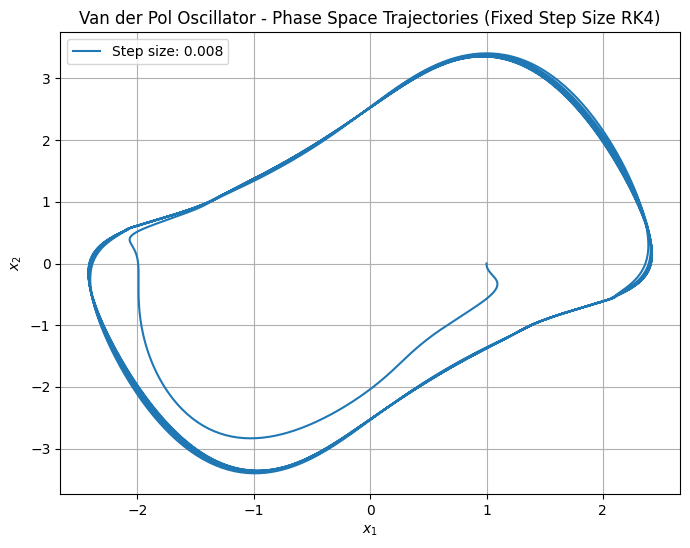

/tmp/ipykernel_139099/1272705708.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

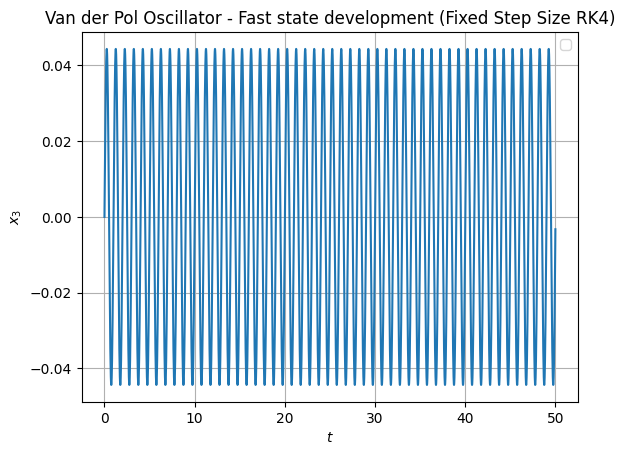

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
mu = 1.0
epsilon_1, epsilon_2, epsilon_3, epsilon_4 = 10, 0.3, 5, 0.0037
d1, d2, d3 = 0.4, 0.4, 40  

# Define periodic control input u
def control_input(t, scale=0.3):
    return scale*np.sin(2 * np.pi * t), scale*np.sin(2 * np.pi * t) # Example: sinusoidal input

# Define the modified Van der Pol oscillator
def van_der_pol(t, X):
    x1, x2, x3 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1 + epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
    dx3 = - (1 / epsilon_4) * x3 + d3 * u_2
    return np.array([dx1, dx2, dx3])

# Fixed-step RK4 integrator
def rk4_integrate(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions
X0 = [1.0, 0.0, 0.0]
t_span = (0, 50)  # Time range

# Different step sizes for integration
step_size = 0.008  # Decreasing step sizes, RUKU fails for 0.03

plt.figure(figsize=(8, 6))

# Solve the ODE using RK4 with a fixed step size
t_vals, X_vals = rk4_integrate(van_der_pol, X0, t_span, step_size)

# Extract solutions
x1, x2, x3 = X_vals[:, 0], X_vals[:, 1],  X_vals[:, 2]

# Plot trajectories
plt.plot(x1, x2, label=f"Step size: {step_size}")

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Van der Pol Oscillator - Phase Space Trajectories (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show()

# Plot the the fast state over time
plt.plot(t_vals, x3)
plt.xlabel("$t$")
plt.ylabel("$x_3$")
plt.title("Van der Pol Oscillator - Fast state development (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show



Next, compare with dynamics obtained when x3 is neglected

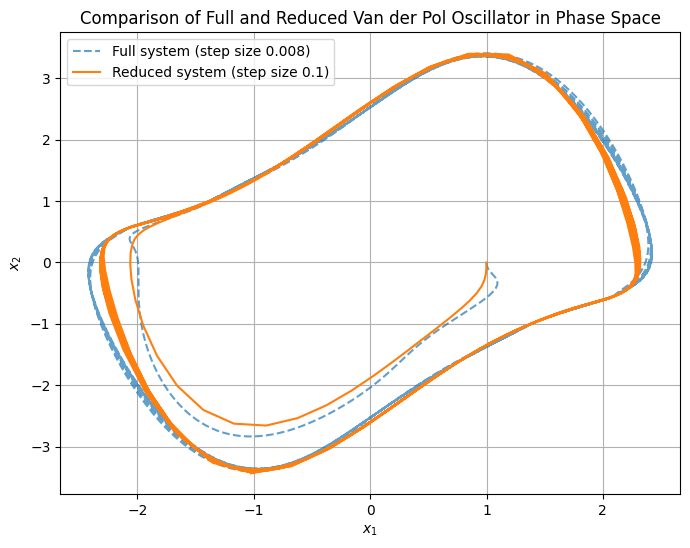

In [2]:
# Define the reduced Van der Pol oscillator (ignoring x3)
def reduced_van_der_pol(t, X):
    x1, x2 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1  # Removed epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + d2 * u_2  # Removed epsilon_3 * x3
    return np.array([dx1, dx2])

# RK4 integration for the reduced system
def rk4_integrate_reduced(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions (only x1 and x2)
X0_reduced = [1.0, 0.0]
new_step_size = 0.1  # Choose a new step size

# Integrate the reduced system
t_vals_reduced, X_vals_reduced = rk4_integrate_reduced(reduced_van_der_pol, X0_reduced, t_span, new_step_size)

# Extract solutions
x1_reduced, x2_reduced = X_vals_reduced[:, 0], X_vals_reduced[:, 1]

# Plot comparison of full and reduced system
plt.figure(figsize=(8, 6))

# Plot the full system's trajectory (from the first cell)
plt.plot(x1, x2, label=f"Full system (step size {step_size})", linestyle='dashed', alpha=0.7)

# Plot the reduced system's trajectory
plt.plot(x1_reduced, x2_reduced, label=f"Reduced system (step size {new_step_size})", linestyle='solid')

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Comparison of Full and Reduced Van der Pol Oscillator in Phase Space")
plt.legend()
plt.grid()
plt.show()



Next, we check that using the approximate model actually leads to more accurate predictions of x1 and x2 for large step sizes. We assume a constant u in the simulation and consider the full model integrated wtih step size 0.001 as ground truth.

/tmp/ipykernel_139099/1541934725.py:25: RuntimeWarning: overflow encountered in scalar multiply
  dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
/tmp/ipykernel_139099/1541934725.py:25: RuntimeWarning: overflow encountered in scalar power
  dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
/tmp/ipykernel_139099/1541934725.py:25: RuntimeWarning: invalid value encountered in scalar add
  dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
/tmp/ipykernel_139099/1541934725.py:162: RuntimeWarning: overflow encountered in scalar power
  sum_sq_error_full += dx1**2 + dx2**2


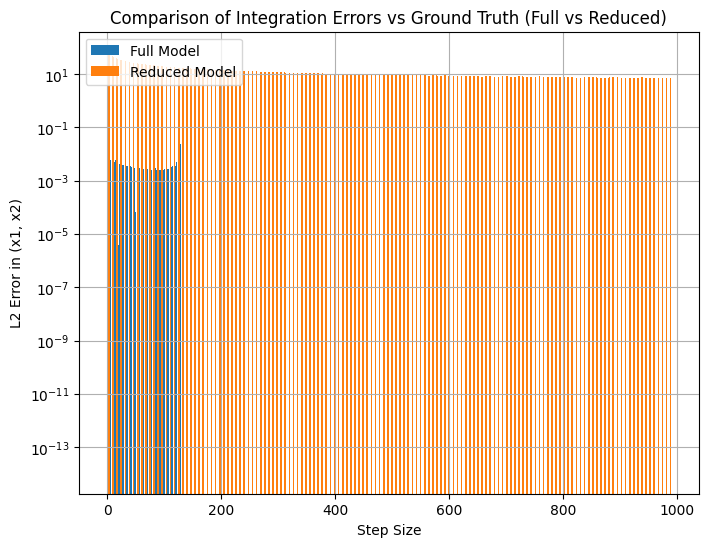

In [3]:
import numpy as np
import matplotlib.pyplot as plt

####################
# 1) Constant Control Input
####################
def control_input_constant(t):
    """Returns a constant control input."""
    return 0.3, 0.3  # Adjust as needed

####################
# 2) Full System with Fast Mode
####################
def van_der_pol_full_constant(t, X, mu=1.0, 
                              epsilon_1=10, epsilon_2=0.3, epsilon_3=5, epsilon_4=0.005, 
                              d1=0.7, d2=0.7, d3=40):
    """
    Full Van der Pol system including the fast mode x3.
    Uses a constant control input.
    """
    x1, x2, x3 = X
    u_1, u_2 = control_input_constant(t)

    dx1 = x2 + d1 * u_1 + epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
    dx3 = - (1 / epsilon_4) * x3 + d3 * u_2
    return np.array([dx1, dx2, dx3])

####################
# 3) Reduced System (No Fast Mode)
####################
def van_der_pol_reduced_constant(t, X, mu=1.0, epsilon_2=0.3, d1=0.7, d2=0.7):
    """
    Reduced Van der Pol system neglecting x3.
    Uses a constant control input.
    """
    x1, x2 = X
    u_1, u_2 = control_input_constant(t)

    dx1 = x2 + d1 * u_1  # Removed epsilon_1*x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + d2 * u_2  # Removed epsilon_3*x3
    return np.array([dx1, dx2])

####################
# 4) RK4 Integrators
####################
def rk4_integrate_full(f, X0, t_span, step_size):
    """
    RK4 integration for the full model (3D state).
    """
    t_start, t_end = t_span
    # Ensure we don't go past t_end due to floating-point increments:
    t_values = []
    t = t_start
    while t < t_end - 1e-15:
        t_values.append(t)
        t += step_size
    # Make sure we include the final time exactly:
    t_values.append(t_end)
    t_values = np.array(t_values, dtype=float)
    
    X_values = np.zeros((len(t_values), len(X0)))
    X = np.array(X0, dtype=float)

    for i, t_val in enumerate(t_values):
        X_values[i] = X
        if i == len(t_values) - 1:
            break  # no further step since we're at end
        h = step_size if (t_val + step_size <= t_end) else (t_end - t_val)
        
        k1 = h * f(t_val, X)
        k2 = h * f(t_val + 0.5 * h, X + 0.5 * k1)
        k3 = h * f(t_val + 0.5 * h, X + 0.5 * k2)
        k4 = h * f(t_val + h,        X + k3)
        X += (k1 + 2*k2 + 2*k3 + k4) / 6.0

    return t_values, X_values

def rk4_integrate_reduced(f, X0, t_span, step_size):
    """
    RK4 integration for the reduced model (2D state).
    """
    t_start, t_end = t_span
    t_values = []
    t = t_start
    while t < t_end - 1e-15:
        t_values.append(t)
        t += step_size
    t_values.append(t_end)
    t_values = np.array(t_values, dtype=float)
    
    X_values = np.zeros((len(t_values), len(X0)))
    X = np.array(X0, dtype=float)

    for i, t_val in enumerate(t_values):
        X_values[i] = X
        if i == len(t_values) - 1:
            break
        h = step_size if (t_val + step_size <= t_end) else (t_end - t_val)
        
        k1 = h * f(t_val, X)
        k2 = h * f(t_val + 0.5 * h, X + 0.5 * k1)
        k3 = h * f(t_val + 0.5 * h, X + 0.5 * k2)
        k4 = h * f(t_val + h,        X + k3)
        X += (k1 + 2*k2 + 2*k3 + k4) / 6.0

    return t_values, X_values

####################
# 5) High-Accuracy "Ground Truth"
####################
t_span = (0, 2)          # Simulation time range
X0_full = [1.0, 0.0, 0.0] # Initial condition for full system
X0_reduced = [1.0, 0.0]   # Initial condition for reduced system

fine_step = 0.001
t_fine, X_fine = rk4_integrate_full(
    van_der_pol_full_constant, X0_full, t_span, fine_step
)

# Ground truth x1, x2 (ignore x3 for error comparisons)
x1_fine = X_fine[:, 0]
x2_fine = X_fine[:, 1]

####################
# 6) Compare Various Step Sizes
####################

step_sizes = np.arange(0.001, 0.1, 0.0001).tolist()#np.arange(0.013, 0.015, 0.0000025).tolist()  # Adjust as desired

errors_full = []
errors_reduced = []

for dt in step_sizes:
    # (a) Integrate the full (exact) system with step size dt
    t_coarse_full, X_coarse_full = rk4_integrate_full(
        van_der_pol_full_constant, X0_full, t_span, dt
    )
    x1_coarse_full = X_coarse_full[:, 0]
    x2_coarse_full = X_coarse_full[:, 1]

    # (b) Integrate the reduced system with step size dt
    t_coarse_red, X_coarse_red = rk4_integrate_reduced(
        van_der_pol_reduced_constant, X0_reduced, t_span, dt
    )
    x1_coarse_red = X_coarse_red[:, 0]
    x2_coarse_red = X_coarse_red[:, 1]

    # (c) Compare each solution to ground truth at matching times
    #     We find the corresponding index in the fine solution by rounding t/dt_fine
    #     and accumulate an L2 norm of the (x1, x2) errors over time.

    # Full model error
    sum_sq_error_full = 0.0
    for i, t_val in enumerate(t_coarse_full):
        idx_fine = int(round(t_val / fine_step))
        # Clamp to avoid out-of-range index
        idx_fine = min(idx_fine, len(x1_fine) - 1)
        
        dx1 = x1_coarse_full[i] - x1_fine[idx_fine]
        dx2 = x2_coarse_full[i] - x2_fine[idx_fine]
        sum_sq_error_full += dx1**2 + dx2**2
    error_full = np.sqrt(sum_sq_error_full)  # L2 norm over time points
    errors_full.append(error_full)

    # Reduced model error
    sum_sq_error_red = 0.0
    for i, t_val in enumerate(t_coarse_red):
        idx_fine = int(round(t_val / fine_step))
        # Clamp
        idx_fine = min(idx_fine, len(x1_fine) - 1)
        
        dx1 = x1_coarse_red[i] - x1_fine[idx_fine]
        dx2 = x2_coarse_red[i] - x2_fine[idx_fine]
        sum_sq_error_red += dx1**2 + dx2**2
    error_reduced = np.sqrt(sum_sq_error_red)  # L2 norm
    errors_reduced.append(error_reduced)

####################
# 7) Bar Plot of Errors
####################
x_positions = np.arange(len(step_sizes))
bar_width = 0.4

plt.figure(figsize=(8, 6))
plt.bar(x_positions - bar_width/2, errors_full, width=bar_width, label='Full Model')
plt.bar(x_positions + bar_width/2, errors_reduced, width=bar_width, label='Reduced Model')
#plt.xticks(x_positions, [str(dt) for dt in step_sizes])
plt.xlabel("Step Size")
plt.ylabel("L2 Error in (x1, x2)")
plt.yscale('log')
plt.title("Comparison of Integration Errors vs Ground Truth (Full vs Reduced)")
plt.legend()
plt.grid(True)
plt.show()



Now moving towards the MPC setting: Create and visualize a simple trajectory that we want to track

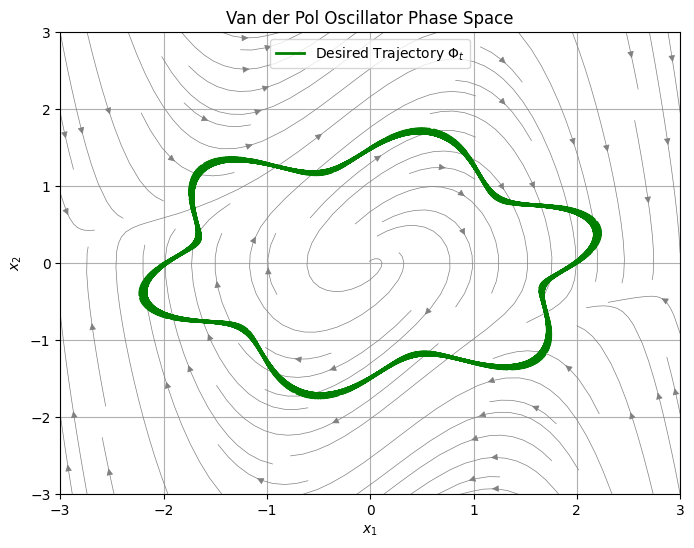

In [6]:
from plotting_utils import plot_phase_space

def Phi_t(t):
    omega_1 = 2  # Base ellipse frequency
    alpha_1 = 2  # Major axis length
    alpha_2 = 1.5  # Minor axis length
    
    beta = 0.3  # Oscillation magnitude
    nu = 6 * omega_1  # Frequency of normal oscillation
    
    # Base ellipse
    x1 = alpha_1 * np.sin(omega_1 * t)
    x2 = alpha_2 * np.cos(omega_1 * t)
    
    # Tangent vector
    Tx = alpha_1 * omega_1 * np.cos(omega_1 * t)
    Ty = -alpha_2 * omega_1 * np.sin(omega_1 * t)
    
    # Normal vector (rotated tangent)
    Nx = alpha_2 * omega_1 * np.sin(omega_1 * t)
    Ny = alpha_1 * omega_1 * np.cos(omega_1 * t)
    
    # Normalize the normal vector
    norm = np.sqrt(Nx**2 + Ny**2)
    Nx /= norm
    Ny /= norm
    
    # Add oscillation in the normal direction
    x1_perturbed = x1 + beta * Nx * np.sin(nu * t)
    x2_perturbed = x2 + beta * Ny * np.sin(nu * t)
    
    return x1_perturbed, x2_perturbed


plot_phase_space(Phi_t)

Next, we compare the behaviour with the following appraoches with a comparable number of stages and describe our interpretation of the observed behaviour:

0) Baseline MPC: Exact model with a small step size of 0.008 and a long horizon.

1) exact model with small step sizes of 0.008 and 15 stages. The MPC is to myopic and has trouble satisfying the constraints.

2) exact model with larger step sizes of 0.02 and 15 stages. The step size is too large for the model with fast dynamics and causes divergence.

3) approximate model and larger step sizes. The model error prevents from accurate tracking.

4) Exact model with the same step size schedule as in 5). The MPC also shows undesired behaviour. 

5) Mixed model MPC with appropriate model schedule. The exact model is integrated with a small step size of 0.008 and the approximate model that captures the slow dynamics is integrated with larger steps of 0.02. The observed behaviour is close to the behaviour of the baseline 0). The desired behaviour reflects in comparable costs to 0).

For a fair comparison, all MPCs are applied with the same frequency. Note that for 2) and 3) the initial step size is not consistent with the frequency. We also tried assigning an initial step size of 0.008 and then use the larger step sizes, in order to let the MPC plan with the step size corresponding to the frequency. We observed that this did not change the results.


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742366589812.so
rm -f vdp_3d_1742366589812_constraints/vdp_3d_1742366589812_constr_h_fun_jac_uxt_zt.o vdp_3d_1742366589812_constraints/vdp_3d_1742366589812_constr_h_fun.o vdp_3d_1742366589812_constraints/vdp_3d_1742366589812_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742366589812_constraints/vdp_3d_1742366589812_constr_h_e_fun.o vdp_3d_1742366589812_cost/vdp_3d_1742366589812_cost_y_0_fun.o vdp_3d_1742366589812_cost/vd

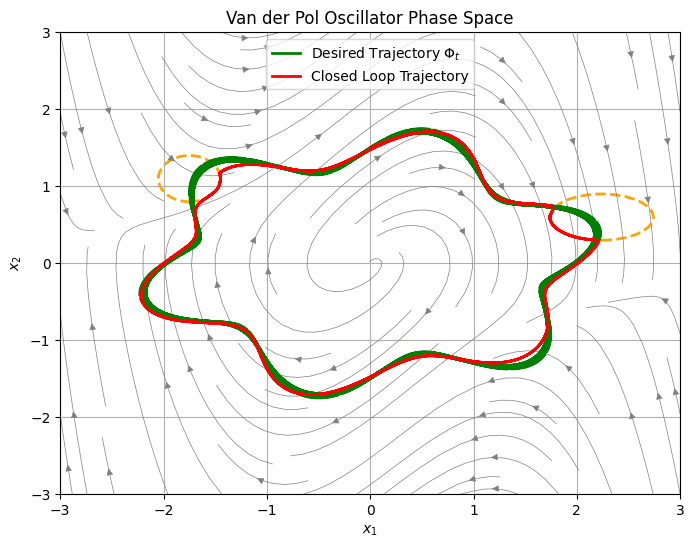


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742366599680.so
rm -f vdp_3d_1742366599680_constraints/vdp_3d_1742366599680_constr_h_fun_jac_uxt_zt.o vdp_3d_1742366599680_constraints/vdp_3d_1742366599680_constr_h_fun.o vdp_3d_1742366599680_constraints/vdp_3d_1742366599680_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742366599680_constraints/vdp_3d_1742366599680_constr_h_e_fun.o vdp_3d_1742366599680_cost/vdp_3d_1742366599680_cost_y_0_fun.o vdp_3d_1742366599680_cost/vd

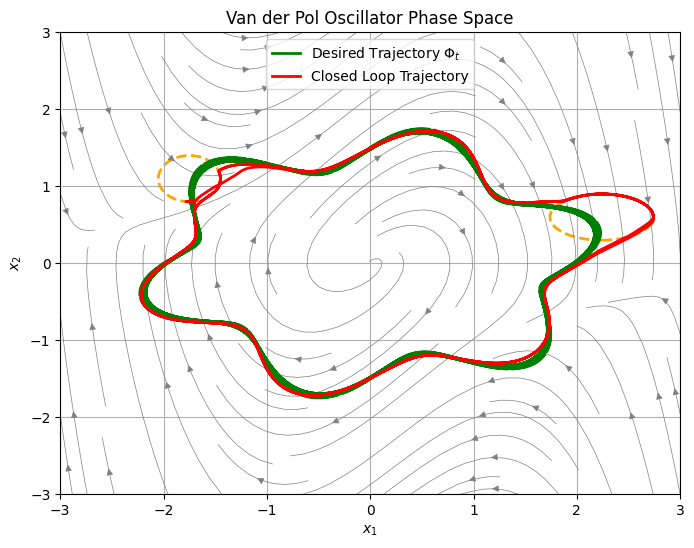


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742366603813.so
rm -f vdp_3d_1742366603813_constraints/vdp_3d_1742366603813_constr_h_fun_jac_uxt_zt.o vdp_3d_1742366603813_constraints/vdp_3d_1742366603813_constr_h_fun.o vdp_3d_1742366603813_constraints/vdp_3d_1742366603813_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742366603813_constraints/vdp_3d_1742366603813_constr_h_e_fun.o vdp_3d_1742366603813_cost/vdp_3d_1742366603813_cost_y_0_fun.o vdp_3d_1742366603813_cost/vd

/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/multi_fidelity_MPC_fast_slow/utils.py:63: RuntimeWarning: invalid value encountered in matmul
  stage_cost = x_traj[step][:2].T @ mpc.opts.Q_2d @ x_traj[step][:2] +  u_opt.T @ mpc.opts.R_2d @ u_opt


[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPolMPC] OCP solver returned status 1.
[VanDerPol

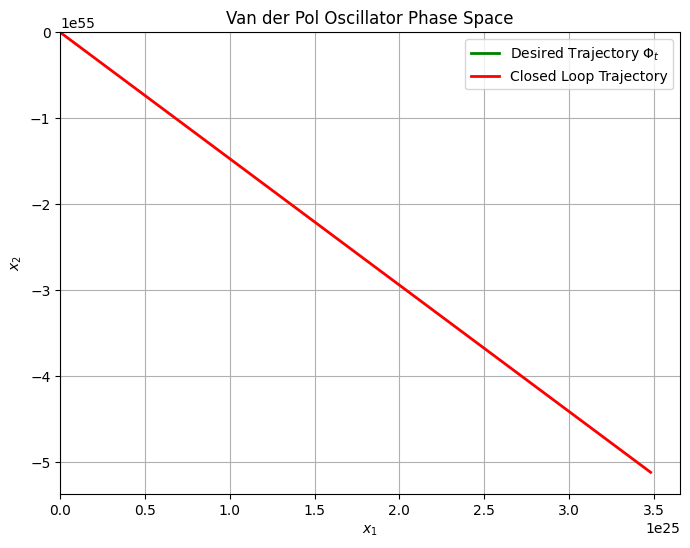


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_2d_1742366607276.so
rm -f vdp_2d_1742366607276_constraints/vdp_2d_1742366607276_constr_h_fun_jac_uxt_zt.o vdp_2d_1742366607276_constraints/vdp_2d_1742366607276_constr_h_fun.o vdp_2d_1742366607276_constraints/vdp_2d_1742366607276_constr_h_e_fun_jac_uxt_zt.o vdp_2d_1742366607276_constraints/vdp_2d_1742366607276_constr_h_e_fun.o vdp_2d_1742366607276_cost/vdp_2d_1742366607276_cost_y_0_fun.o vdp_2d_1742366607276_cost/vd

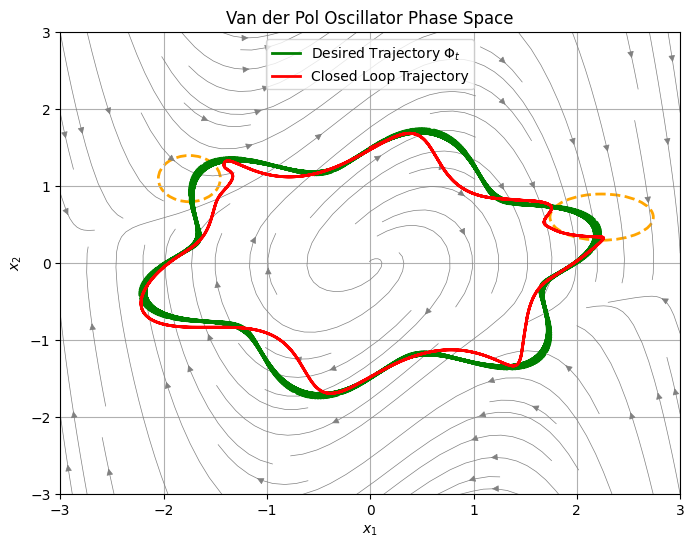


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742366611457.so
rm -f vdp_3d_1742366611457_constraints/vdp_3d_1742366611457_constr_h_fun_jac_uxt_zt.o vdp_3d_1742366611457_constraints/vdp_3d_1742366611457_constr_h_fun.o vdp_3d_1742366611457_constraints/vdp_3d_1742366611457_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742366611457_constraints/vdp_3d_1742366611457_constr_h_e_fun.o vdp_3d_1742366611457_cost/vdp_3d_1742366611457_cost_y_0_fun.o vdp_3d_1742366611457_cost/vd

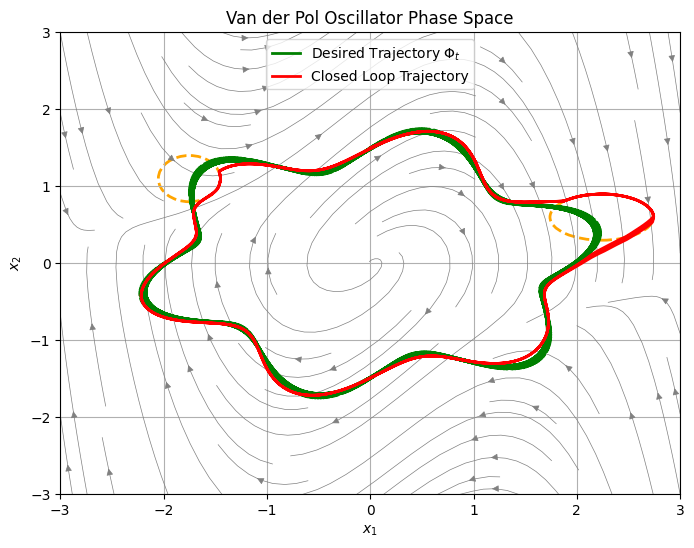

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_10_1_5_20250318_234335_944174.c: In function ‘multiphase_ocp_10_1_5_20250318_234335_944174_acados_create_with_discretization’:
acados_solver_multiphase_ocp_10_1_5_20250318_234335_944174.c:1348:25: warning: too many arguments for format [-Wformat-extra-args]
 1348 |         fprintf(stderr, "multiphase_ocp_10_1_5_20250318_234335_944174_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o vdp_3d_1742366615944_model/vdp_3d_1742366615944_expl_vde_forw.o vdp_3d_1742366615944_model/vdp_3d_1742366615944_expl_vde_forw.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o vdp_3d_1742366615944_model/vdp_3d_1742366615944_expl_vde_adj.o vdp_3d_1742366615944_model/vdp_3d_1742366615944_expl_vde_

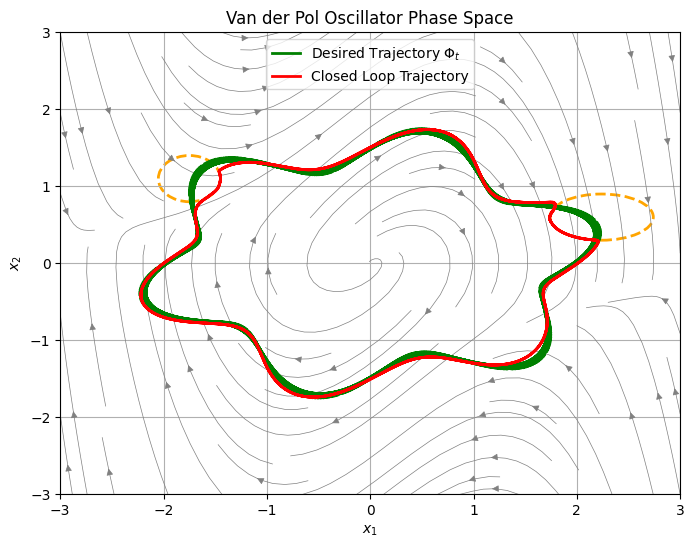

In [17]:
from Van_der_pol_MPC import VanDerPolMPC, VanDerPolMPCOptions
from copy import deepcopy
from utils import simulate_closed_loop

# Parameters for experiment
t0 = 0.0
x01, x02 = Phi_t(t=t0) # Set initial state on the trajectory
x03 = 0.0
x0 = np.vstack((x01, x02, x03))

mpc_opts_base = VanDerPolMPCOptions(
    # dynamics
    mu=mu,
    epsilon_1=epsilon_1,
    epsilon_2=epsilon_2,
    epsilon_3=epsilon_3,
    epsilon_4=epsilon_4,
    d1=d1,
    d2=d2,
    d3=d3,

    # Define two ellipses to avoid
    ellipse_centers=np.array([
        [-1.75, 1.1],  # Center of first ellipse
        [2.24, 0.6]   # Center of second ellipse
    ]),
    ellipse_half_axes=np.array([
        [0.3, 0.3],   # Half-axis lengths (a, b) for first ellipse
        [0.5, 0.3]    # Half-axis lengths (a, b) for second ellipse
    ])
)

### Create Simulator, model integrated with small step size treated as ground truth ###
dt_sim = 0.001
mpc_opts_sim_solver = deepcopy(mpc_opts_base)
mpc_opts_sim_solver.N = 1
mpc_opts_sim_solver.step_size_list = [dt_sim]
mpc_opts_sim_solver.switch_stage = 10
mpc_sim_solver = VanDerPolMPC(mpc_opts_sim_solver, Phi_t)
sim_solver = mpc_sim_solver.acados_sim_solver_3d

# Simulation parameter
duration = 10

### Baseline MPC ###
mpc_opts_baseline = deepcopy(mpc_opts_base)
N = 50
mpc_opts_baseline.N = N
mpc_opts_baseline.step_size_list = [0.008] * N
mpc_opts_baseline.switch_stage = N+1 # no switching, use exact model
mpc_baseline = VanDerPolMPC(mpc_opts_baseline, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_baseline, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("Baseline mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_baseline, closed_loop_traj=x_traj)


### 1) exact model with small step size ###
mpc_opts_1 = deepcopy(mpc_opts_base)
N = 15
mpc_opts_1.N = N
mpc_opts_1.step_size_list = [0.008] * N
mpc_opts_1.switch_stage = N+1 # no switching, usage of exact model
mpc_1 = VanDerPolMPC(mpc_opts_1, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_1, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("1) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_1, closed_loop_traj=x_traj)

### 2) Exact model with larger step size ###
mpc_opts_2 = deepcopy(mpc_opts_base)
N = 15
mpc_opts_2.N = N
mpc_opts_2.step_size_list = [0.02] * N
mpc_opts_2.switch_stage = N+1 # no switching, usage of exact model
mpc_2 = VanDerPolMPC(mpc_opts_2, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_2, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("2) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_2, closed_loop_traj=x_traj)

### 3) Approximate model with larger step sizes ### 
mpc_opts_3 = deepcopy(mpc_opts_base)
N = 15
mpc_opts_3.N = N
mpc_opts_3.step_size_list = [0.02] * N
mpc_opts_3.switch_stage = 0 #  use approximate model from stage 1 on
mpc_3 = VanDerPolMPC(mpc_opts_3, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_3, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("3) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_3, closed_loop_traj=x_traj)

### 4) Exact model with same step size schedule as in 5) ###
mpc_opts_4 = deepcopy(mpc_opts_base)
N = 15
mpc_opts_4.N = N
mpc_opts_4.step_size_list = [0.008] * 10 + [0.02]*5
mpc_opts_4.switch_stage = N+1 # suse exact model only
mpc_4 = VanDerPolMPC(mpc_opts_4, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_4, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("4) mean costs (Note that this MPC does not adhere to the constraints):", np.mean(costs))
plot_phase_space(Phi_t, mpc_4, closed_loop_traj=x_traj)

### 5) Mixed model MPC ###
mpc_opts_5 = deepcopy(mpc_opts_base)
N = 15
mpc_opts_5.N = N
mpc_opts_5.step_size_list = [0.008] * 10 + [0.02]*5
mpc_opts_5.switch_stage = 10 # switch after stage 10
mpc_5 = VanDerPolMPC(mpc_opts_5, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc_5, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=8)
print("5) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_5, closed_loop_traj=x_traj)

Let's simulate in closed loop and see if we succesfully track!

[VanDerPolMPC] OCP solver returned status 3.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[VanDerPolMPC] OCP solver returned status 2.
[[ 3.56478259  1.25057816]
 [ 3.78556103  1.09126155]
 [ 4.06965684  0.95525741]
 ...
 [ 9.45264844 -3.08823226]
 [ 8.54227075 -2.95237905]
 [ 7.55084379 -2.7925059 ]]
15.087592612059344


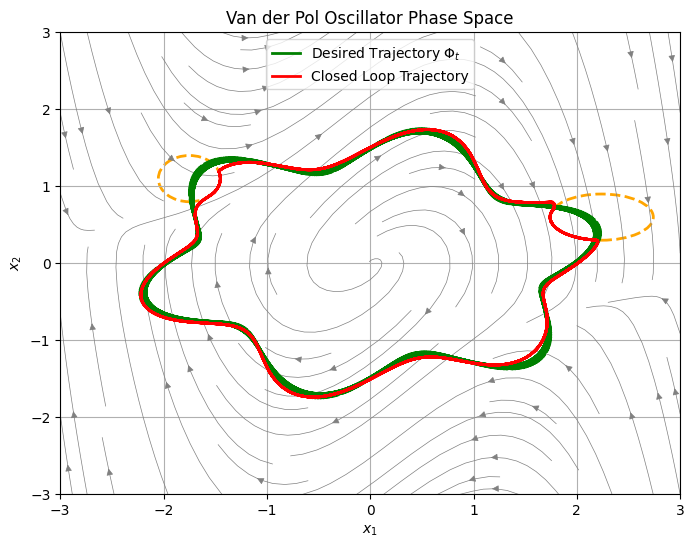

In [11]:
from utils import simulate_closed_loop

duration = 20
x_traj, u_traj, _ = simulate_closed_loop(x0, mpc, duration, sigma_noise=0.0)
print(u_traj)
print(np.max(u_traj))

plot_phase_space(Phi_t, mpc, closed_loop_traj=x_traj)



Next, run an MPC at different Frequencies. For these stable dynamics -> there is not big difference when running the MPC at a higher frequency.

In [ ]:
from copy import deepcopy
# Define simulation parameters
dt_sim = 0.001
duration = 10
sigma_noise = 0.0

# Create simulation solver
mpc_opts_sim_solver = deepcopy(mpc_opts)
mpc_opts_sim_solver.N = 1
mpc_opts_sim_solver.step_size_list = [dt_sim]
mpc_opts_sim_solver.switch_stage = 10
mpc_sim_solver = VanDerPolMPC(mpc_opts_sim_solver, Phi_t)
sim_solver = mpc_sim_solver.acados_sim_solver_3d

# Run closed-loop simulation
x_traj, u_traj, costs = simulate_closed_loop(
    x0, mpc, duration, sigma_noise=sigma_noise, 
    sim_solver=sim_solver, control_step=1)

plot_phase_space(Phi_t, mpc, closed_loop_traj=x_traj)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742361741336.so
rm -f vdp_3d_1742361741336_constraints/vdp_3d_1742361741336_constr_h_fun_jac_uxt_zt.o vdp_3d_1742361741336_constraints/vdp_3d_1742361741336_constr_h_fun.o vdp_3d_1742361741336_constraints/vdp_3d_1742361741336_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742361741336_constraints/vdp_3d_1742361741336_constr_h_e_fun.o vdp_3d_1742361741336_cost/vdp_3d_1742361741336_cost_y_0_fun.o vdp_3d_1742361741336_cost/vd

/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/multi_fidelity_MPC_fast_slow/Van_der_pol_MPC.py:345: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if stage is not 0 and stage == self.opts.switch_stage: # 0 stage means only 2d model and no switch
/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/multi_fidelity_MPC_fast_slow/Van_der_pol_MPC.py:345: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if stage is not 0 and stage == self.opts.switch_stage: # 0 stage means only 2d model and no switch


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Define simulation parameters
dt_sim = 0.001
time_horizon = 0.05
duration = 10
sigma_noise = 0.0
step_sizes = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]  # Multiples of dt_sim

# Create simulation solver
mpc_opts_sim_solver = deepcopy(mpc_opts)
mpc_opts_sim_solver.N = 1
mpc_opts_sim_solver.step_size_list = [dt_sim]
mpc_opts_sim_solver.switch_stage = 10
mpc_sim_solver = VanDerPolMPC(mpc_opts_sim_solver, Phi_t)
sim_solver = mpc_sim_solver.acados_sim_solver_3d

# Store costs for each step size
costs_list = []
frequencies = [1.0 / step for step in step_sizes]

# Loop over different step sizes
for step_size in step_sizes:
    N = int(time_horizon / step_size)

    mpc_opts_freq = deepcopy(mpc_opts)
    mpc_opts_freq.N = N
    mpc_opts_freq.switch_stage = N + 1
    mpc_opts_freq.step_size_list = [step_size] * N
    mpc_freq = VanDerPolMPC(mpc_opts_freq, Phi_t)

    # Run closed-loop simulation
    x_traj, u_traj, costs = simulate_closed_loop(
        x0, mpc_freq, duration, sigma_noise=sigma_noise, 
        sim_solver=sim_solver, control_step=int(step_size/ dt_sim)
    )
    
    costs_list.append(np.mean(costs))

    # Plot phase space
    plot_phase_space(Phi_t, mpc_freq, closed_loop_traj=x_traj)

    del mpc_freq.acados_ocp_solver # agrbage collection, otherwise issues with different solvers
    del mpc_freq

# Save the costs
np.save("costs.npy", np.array(costs_list))
np.save("frequencies.npy", np.array(frequencies))

# Plot cost vs. frequency
plt.figure()
plt.plot(frequencies, costs_list, marker='o', linestyle='-')
plt.xlabel("Control Frequency (1/dt)")
plt.ylabel("Total Cost")
plt.title("Control Frequency vs. Cost")
plt.grid(True)
plt.show()



got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1742361453516.so
rm -f vdp_3d_1742361453516_constraints/vdp_3d_1742361453516_constr_h_fun_jac_uxt_zt.o vdp_3d_1742361453516_constraints/vdp_3d_1742361453516_constr_h_fun.o vdp_3d_1742361453516_constraints/vdp_3d_1742361453516_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1742361453516_constraints/vdp_3d_1742361453516_constr_h_e_fun.o vdp_3d_1742361453516_cost/vdp_3d_1742361453516_cost_y_0_fun.o vdp_3d_1742361453516_cost/vd